In [2]:
import torch
import os
import h5py
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from utils.PathDataset import Pathology_Dataset_test
from torch.utils.data import Dataset, DataLoader
from utils.T1Dataset import T1Dataset_regression_mr_path_test
from models.SENet import Model_path_mr
from lifelines.utils import concordance_index
from models.MLP import MLP
import torch
import torchtuples as tt
from utils.img_processing import convert_path,normalize_min_max
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('G:\glioma\\final_data\glioma_survive\\5hmc\huashan_5hmc_.csv')

In [25]:
df.head(1)

,patient,score_gene,score,IDH,WHO,Age,Gender,survival_month,status_dead
0,Pan_Jing_Wei,0.457889,0.186934,0,4,36.0,1,27.13,1


In [4]:
df_train_, df_test, y_train, y_test = train_test_split(df,df['patient'],test_size=0.2,random_state=201)
df_train, df_val, y_train, y_test = train_test_split(df_train_,df_train_['patient'],test_size=0.2,random_state=2018)
df_train_[['score','WHO','Age','Gender','IDH','score_gene']] = df_train_[['score','WHO','Age','Gender','IDH','score_gene']].astype('float32')
get_target = lambda df_train_: (df_train_['survival_month'].values, df_train_['status_dead'].values)
y_train = get_target(df_train_)
train_feature = df_train_[['score','WHO','Age','Gender','IDH','score_gene']].values

df_test[['score','WHO','Age','Gender','IDH','score_gene']] = df_test[['score','WHO','Age','Gender','IDH','score_gene']].astype('float32')
val_feature = df_test[['score','WHO','Age','Gender','IDH','score_gene']].values
get_target = lambda df_test: (df_test['survival_month'].values, df_test['status_dead'].values)
y_val = get_target(df_test)
val = tt.tuplefy(val_feature, y_val)

def calculate_param(df_TCGA_loc_M, model_cph1):
    df_TCGA_loc_M[['score','WHO','Age','Gender','IDH','score_gene']] = df_TCGA_loc_M[['score','WHO','Age','Gender','IDH','score_gene']].astype('float32')
    feature_TCGA_loc_M = df_TCGA_loc_M[['score','WHO','Age','Gender','IDH','score_gene']].values
    get_target = lambda df_TCGA_loc_M: (df_TCGA_loc_M['survival_month'].values, df_TCGA_loc_M['status_dead'].values)
    durations_test_ex, events_test_ex = get_target(df_TCGA_loc_M)
    _ = model_cph1.compute_baseline_hazards()
    surv = model_cph1.predict_surv_df(feature_TCGA_loc_M)
    ev = EvalSurv(surv, durations_test_ex, events_test_ex, censor_surv='km')
    time_grid = np.linspace(durations_test_ex.min(), durations_test_ex.max(), 100)
    return ev.concordance_td(),ev.integrated_brier_score(time_grid)

In [5]:
df_train_.to_csv('G:/glioma/final_data/glioma_survive/5hmc/result/train.csv',index = False)
df_val.to_csv('G:/glioma/final_data/glioma_survive/5hmc/result/val.csv',index = False)
df_test.to_csv('G:/glioma/final_data/glioma_survive/5hmc/result/test.csv',index = False)

0:	[0s / 0s],		train_loss: 1.7786,	val_loss: 1.2806
1:	[0s / 0s],		train_loss: 1.5992,	val_loss: 1.2466
2:	[0s / 0s],		train_loss: 1.4896,	val_loss: 1.2239
3:	[0s / 0s],		train_loss: 1.7816,	val_loss: 1.0581
4:	[0s / 0s],		train_loss: 1.7482,	val_loss: 1.0321
5:	[0s / 0s],		train_loss: 1.5601,	val_loss: 1.0108
6:	[0s / 0s],		train_loss: 1.3694,	val_loss: 1.1309
7:	[0s / 0s],		train_loss: 1.6642,	val_loss: 1.0493
8:	[0s / 0s],		train_loss: 1.5358,	val_loss: 1.0222
9:	[0s / 0s],		train_loss: 1.6028,	val_loss: 1.0886
10:	[0s / 0s],		train_loss: 1.4705,	val_loss: 1.1238
11:	[0s / 0s],		train_loss: 1.5246,	val_loss: 1.1350
12:	[0s / 0s],		train_loss: 1.4598,	val_loss: 1.0533
13:	[0s / 0s],		train_loss: 1.4071,	val_loss: 0.9883
14:	[0s / 0s],		train_loss: 1.4150,	val_loss: 0.9092
15:	[0s / 0s],		train_loss: 1.4681,	val_loss: 0.9545
16:	[0s / 0s],		train_loss: 1.6088,	val_loss: 1.0098
17:	[0s / 1s],		train_loss: 1.5006,	val_loss: 1.0397
18:	[0s / 1s],		train_loss: 1.3390,	val_loss: 0.9543
19:

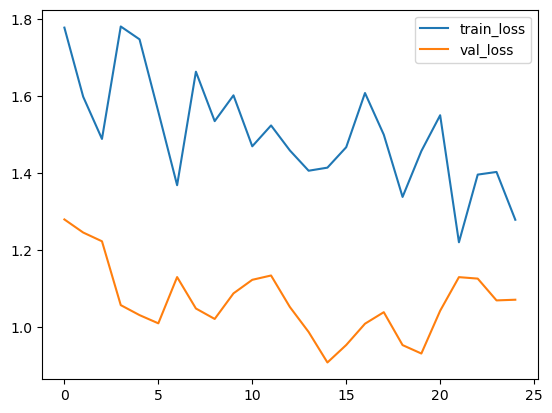

In [77]:
in_features = train_feature.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)
model_cph = CoxPH(net, tt.optim.Adam)
batch_size = 10
lrfinder = model_cph.lr_finder(train_feature, y_train, batch_size, tolerance=10)
# _ = lrfinder.plot()
model_cph.optimizer.set_lr(lrfinder.get_best_lr())
epochs = 30
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model_cph.fit(train_feature, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
_ = log.plot()

In [80]:
print("MM-CoxPH Mutil-Modal-AB")
print("Huashan-Test-Set (c-index, brier scores)",calculate_param(df_test,model_cph))

MM-CoxPH Mutil-Modal-AB
Huashan-Test-Set (c-index, brier scores) (0.8823529411764706, 0.18512555873571884)


In [79]:
model_cph.save_net(os.path.join('G:\glioma\\final_data\glioma_survive\\5hmc\pth','MM-CoxPH Mutil-Modal-AB.pth'))